## **Revisión de Imagenes 360**
---


In [ ]:
import cv2
import numpy as np
import py360convert
import csv
import os
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

carpeta = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\Chigorodo\2. Fotografias 360"
data_dir = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset"
model_path = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\modelo_fachadas.pth"
history_csv = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\historial_analisis.csv"

#### **Revision básica**
---

##### **Funciones**

In [ ]:
def detectar_distorsion_simple(zona, min_longitud=150,max_curvatura=.09,min_contornos_curvos=3,canny1=150, canny2=300):
    """
    Detecta distorsión de bordes de forma rápida:
    - Busca contornos largos y mide su curvatura.
    - Si hay muchos contornos largos y curvos, se considera distorsión.
    """
    gray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny1, canny2)
    contornos, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contornos_largos = [c for c in contornos if cv2.arcLength(c, False) > min_longitud]
    curvos = 0
    for c in contornos_largos:
        if len(c) > 4:
            [vx, vy, x, y] = cv2.fitLine(c, cv2.DIST_L2, 0, 0.01, 0.01)
            puntos = c.reshape(-1, 2)
            dist = np.abs((vy * (puntos[:,0] - x)) - (vx * (puntos[:,1] - y)))
            curvatura = np.mean(dist)
            if curvatura > max_curvatura * 256:
                curvos += 1
    # Si hay al menos min_contornos_curvos curvos, hay distorsión
    distorsion = curvos >= min_contornos_curvos
    return distorsion, edges

def procesar_imagen(nombre_imagen):
    imagen_path = os.path.join(carpeta, nombre_imagen)
    imagen = cv2.imread(imagen_path)
    if imagen is None:
        return None
    # Menor resolución para más velocidad
    cubemap = py360convert.e2c(imagen, face_w=1024, mode='nearest', cube_format='list')
    distorsion_caras, heatmaps, promedios = [], [], []
    exposicion_caras = []
    for i in range(4):
        cara = cubemap[i]
        h, w, _ = cara.shape
        x1, x2 = int(w*0.1), int(w*0.9)
        y1, y2 = int(h*0.1), int(h*0.9)
        zona = cara[y1:y2, x1:x2]
        gray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
        promedios.append(np.mean(gray))
        distorsion, edges = detectar_distorsion_simple(zona)
        distorsion_caras.append(distorsion)
        heatmaps.append(edges)
        exposicion_cara = chequear_exposicion(zona)
        exposicion_caras.append(exposicion_cara)
    promedio_global = np.mean(promedios)
    if promedio_global < 40:
        exposicion_global = "subexpuesta"
    elif promedio_global > 205:
        exposicion_global = "sobreexpuesta"
    else:
        exposicion_global = "correcta"
    distorsion = any(distorsion_caras)
    exposicion_bool = any([e != 'correcta' for e in exposicion_caras])
    return {
        'archivo': nombre_imagen,
        'exposicion': exposicion_bool,  # True si alguna cara está mal expuesta
        'exposicion_caras': exposicion_caras,
        'distorsion': distorsion,
        'distorsion_caras': distorsion_caras,
        'heatmaps': heatmaps
    }
    
def chequear_exposicion(imagen, bajo=45, alto=205, pct_umbral=0.5):
    """
    Clasifica la exposición de una imagen:
    - 'subexpuesta' si más del pct_umbral de los pixeles son muy oscuros.
    - 'sobreexpuesta' si más del pct_umbral de los pixeles son muy claros.
    - 'correcta' en caso contrario.
    """
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    pct_bajo = np.mean(gray < bajo)
    pct_alto = np.mean(gray > alto)
    if pct_bajo > pct_umbral:
        return "subexpuesta"
    elif pct_alto > pct_umbral:
        return "sobreexpuesta"
    else:
        return "correcta"

# --- VISUALIZACIÓN DE IMÁGENES Y HEATMAPS PARA LAS 5 MEJORES Y 5 PEORES ---
def mostrar_varias_imagenes(resultados, n=5):
    if not resultados:
        print("No hay imágenes filtradas para mostrar.")
        return
    seleccion = resultados[:n]
    for idx, fila in enumerate(seleccion):
        img_path = os.path.join(carpeta, fila['archivo'])
        img = cv2.imread(img_path)
        if img is not None:
            cubemap = py360convert.e2c(img, face_w=1024, mode='nearest', cube_format='list')
            titulos = ['Frontal', 'Derecha', 'Trasera', 'Izquierda']
            plt.figure(figsize=(16, 4))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(cv2.cvtColor(cubemap[i], cv2.COLOR_BGR2RGB))
                plt.title(
                    f"{titulos[i]}\n"
                    f"Distorsión: {fila['distorsion_caras'][i]}\n"
                    f"Exposición: {fila['exposicion_caras'][i]}"
                )
                plt.axis('off')
            plt.suptitle(
                f"Imagen #{idx+1}: {fila['archivo']} (Distorsión detectada: {fila['distorsion']})"
            )
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print(f"No se pudo cargar la imagen {fila['archivo']}.")

# --- HEATMAPS DE LAS 4 VISTAS PARA 5 MEJORES Y 5 PEORES ---
def mostrar_heatmaps(resultados, n=5):
    if not resultados:
        print("No hay imágenes filtradas para mostrar mapa de distorsión.")
        return
    seleccion = resultados[:n]
    titulos = ['Frontal','Derecha','Trasera','Izquierda']
    for idx, fila in enumerate(seleccion):
        plt.figure(figsize=(16, 4))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(fila['heatmaps'][i], cmap='hot')
            plt.title(f"{titulos[i]}\nDistorsión: {fila['distorsion_caras'][i]}")
            plt.axis('off')
        plt.suptitle(
            f"Imagen #{idx+1}: {fila['archivo']} (Distorsión detectada: {fila['distorsion']})"
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

##### **Script básico**

In [20]:
imagenes = [f for f in os.listdir(carpeta) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
total_imagenes = len(imagenes)

print(f"Total de imágenes a procesar: {total_imagenes}")

start_time = time.time()
resultados = []
procesadas = 0

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    future_to_img = {executor.submit(procesar_imagen, nombre_imagen): nombre_imagen for nombre_imagen in imagenes}
    for idx, future in enumerate(as_completed(future_to_img), 1):
        resultado = future.result()
        if resultado:
            resultados.append(resultado)
        procesadas += 1
        if procesadas % 10 == 0 or procesadas == total_imagenes:
            elapsed = time.time() - start_time
            avg_time = elapsed / procesadas
            remaining = avg_time * (total_imagenes - procesadas)
            print(f"Procesando imagen {procesadas}/{total_imagenes}")
            print(f"Tiempo transcurrido: {elapsed/60:.2f} min")
            print(f"Tiempo estimado restante: {remaining/60:.2f} min")

total_time = time.time() - start_time
print(f"Procesamiento terminado en {total_time/60:.2f} minutos.")

resultados_filtrados = [
    fila for fila in resultados
    if fila['exposicion'] != 'correcta' or fila['distorsion'] is True
]

Total de imágenes a procesar: 17971
Procesando imagen 10/17971
Tiempo transcurrido: 0.17 min
Tiempo estimado restante: 301.58 min
Procesando imagen 20/17971
Tiempo transcurrido: 0.24 min
Tiempo estimado restante: 211.70 min
Procesando imagen 30/17971
Tiempo transcurrido: 0.29 min
Tiempo estimado restante: 173.17 min
Procesando imagen 40/17971
Tiempo transcurrido: 0.33 min
Tiempo estimado restante: 149.93 min
Procesando imagen 50/17971
Tiempo transcurrido: 0.39 min
Tiempo estimado restante: 140.01 min
Procesando imagen 60/17971
Tiempo transcurrido: 0.44 min
Tiempo estimado restante: 129.90 min
Procesando imagen 70/17971
Tiempo transcurrido: 0.49 min
Tiempo estimado restante: 125.11 min
Procesando imagen 80/17971
Tiempo transcurrido: 0.54 min
Tiempo estimado restante: 121.41 min
Procesando imagen 90/17971
Tiempo transcurrido: 0.59 min
Tiempo estimado restante: 117.36 min
Procesando imagen 100/17971
Tiempo transcurrido: 0.64 min
Tiempo estimado restante: 114.00 min
Procesando imagen 110/1

#### **Exporte y Visualice Resultados**
---

##### **Exportar CSV**

In [21]:
csv_path = os.path.join(carpeta, 'reporte_distorsion.csv')
campos = [
    'archivo',
    'exposicion',         # True/False si alguna cara está mal expuesta
    'exposicion_caras',   # Lista de exposición por cara
    'distorsion',
    'distorsion_caras',
]

with open(csv_path, mode='w', newline='', encoding='utf-8') as archivo_csv:
    writer = csv.DictWriter(archivo_csv, fieldnames=campos)
    writer.writeheader()
    for fila in resultados_filtrados:
        writer.writerow({
            'archivo': fila['archivo'],
            'exposicion': fila['exposicion'],
            'exposicion_caras': fila['exposicion_caras'],
            'distorsion': fila['distorsion'],
            'distorsion_caras': fila['distorsion_caras'],
        })

print("Reporte de Distorsión y exposición:", csv_path)

Reporte de Distorsión y exposición: C:\Users\Juan Camilo\Downloads\Imagenes 360\Chigorodo\2. Fotografias 360\reporte_distorsion.csv


##### **Exportar SHP**

In [22]:
shp_entrada = os.path.join(carpeta, "Centros_Fotos.shp")
shp_salida = os.path.join(carpeta, "imagenes_filtradas.shp")

if os.path.exists(shp_entrada):
    df_nitidez = pd.read_csv(csv_path)
    if not df_nitidez.empty:
        gdf = gpd.read_file(shp_entrada)
        gdf_filtrado = gdf.merge(df_nitidez, left_on='Nombre', right_on='archivo')
        gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
        print(f"SHP filtrado guardado en {shp_salida}")
    else:
        print("No hay imágenes que cumplan los criterios para exportar SHP.")
else:
    print(f"No se encontró el shapefile de entrada: {shp_entrada}")

C:\Users\Juan Camilo\AppData\Local\Temp\ipykernel_1680\1023093079.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'exposicion_caras' to 'exposici_1'
  ogr_write(
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distorsion_caras' to 'distorsi_1'
  ogr_write(


SHP filtrado guardado en C:\Users\Juan Camilo\Downloads\Imagenes 360\Chigorodo\2. Fotografias 360\imagenes_filtradas.shp


##### **Visualice**
---
En esta sección visualice las *imágenes 360* que hayan sido catalogadas como distorsionadas o si encuentra problemas en la exposición.

El primer cuadro muestra 3 imágenes aleatorias del dataset, su intención es obtener información rápida cada vez que se usa el script
El segundo cuadro muestra 5 imágenes del dataset clasificadas como defectuosas

Imagenes aleatorias de muestra:


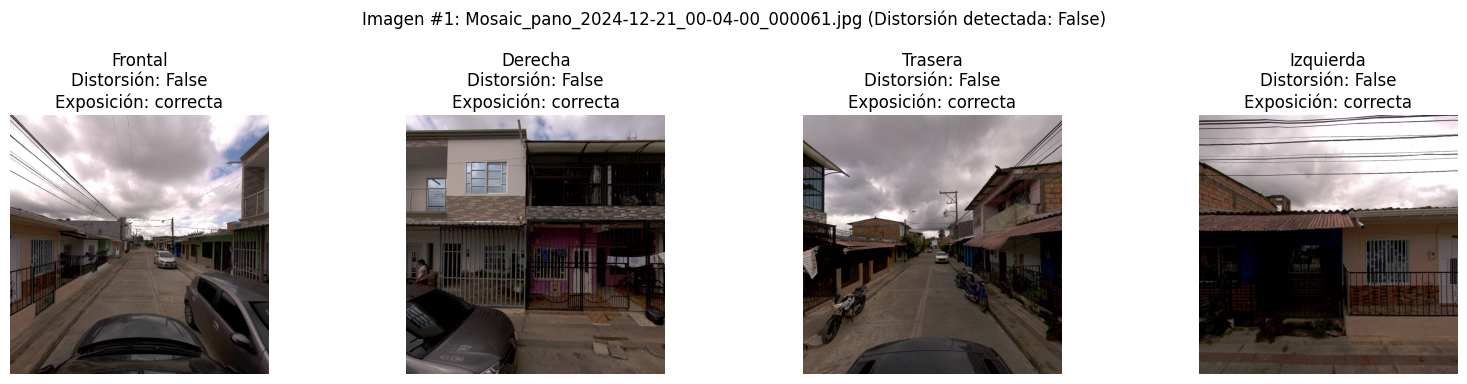

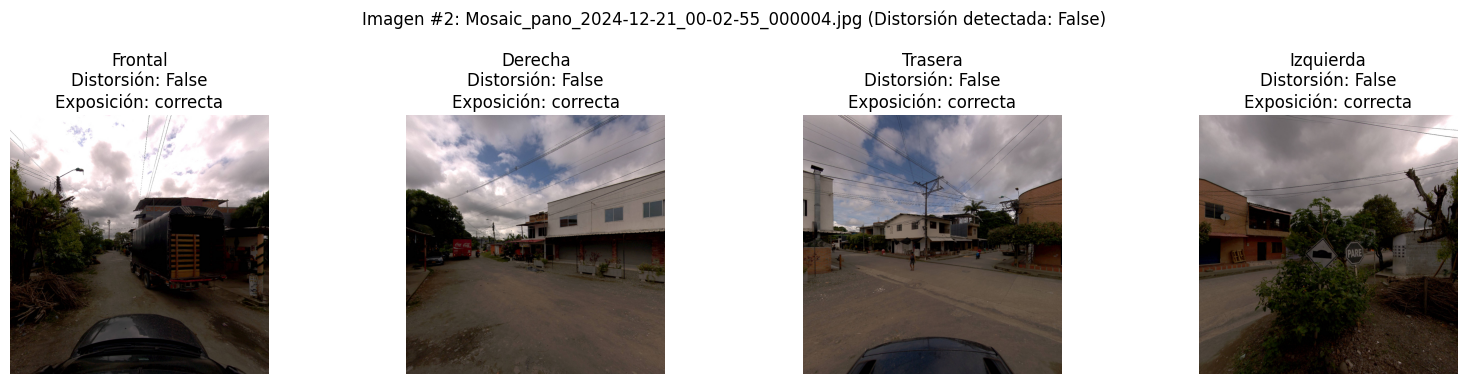

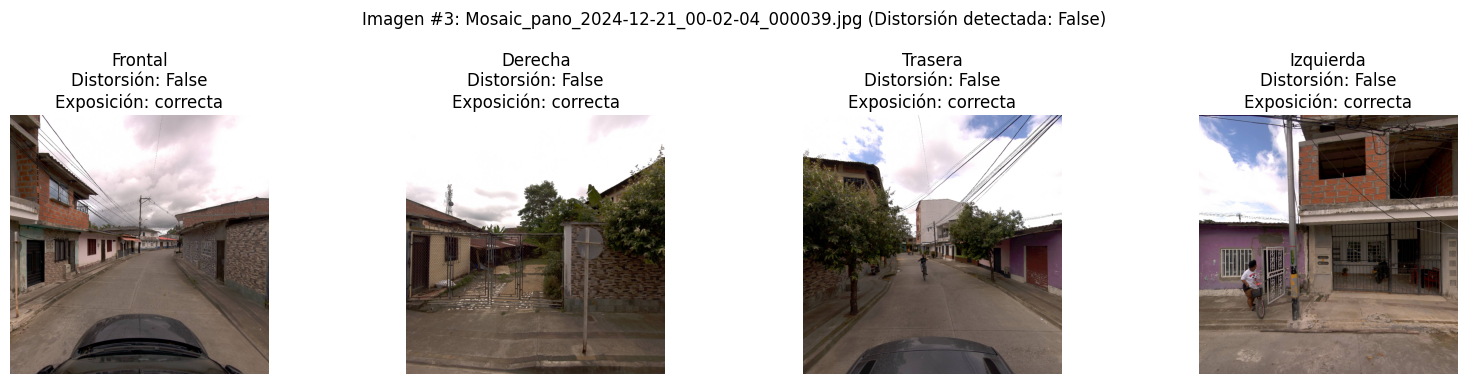

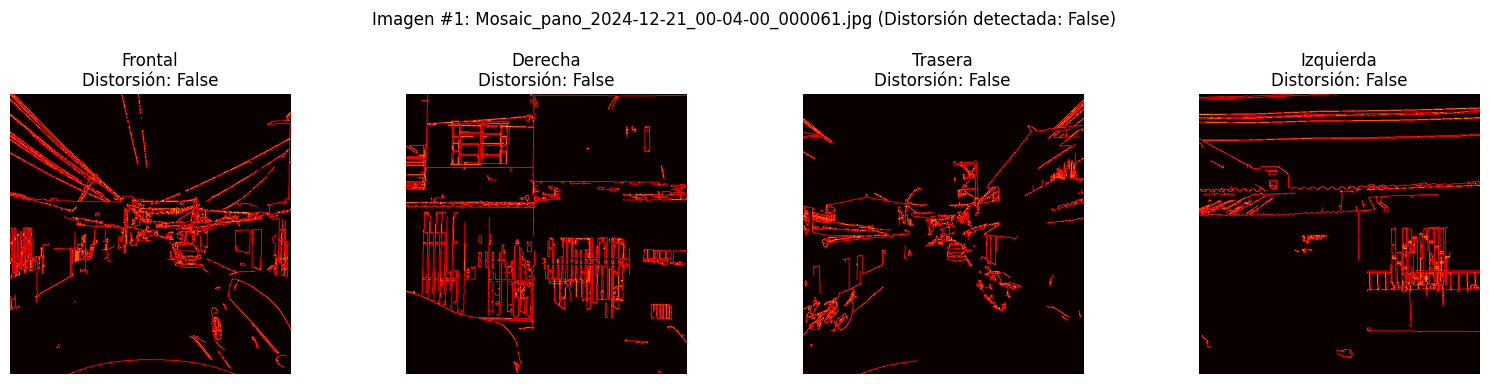

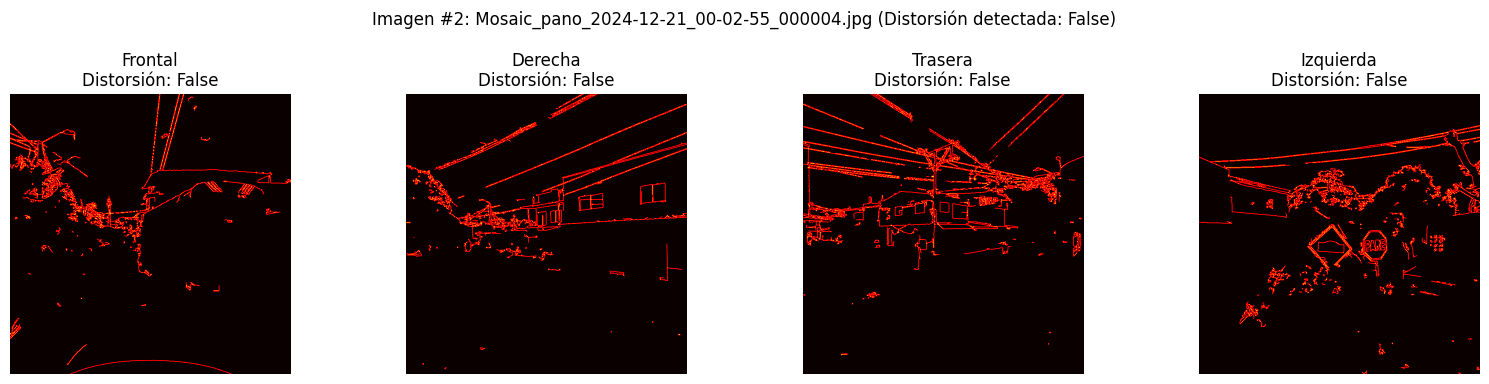

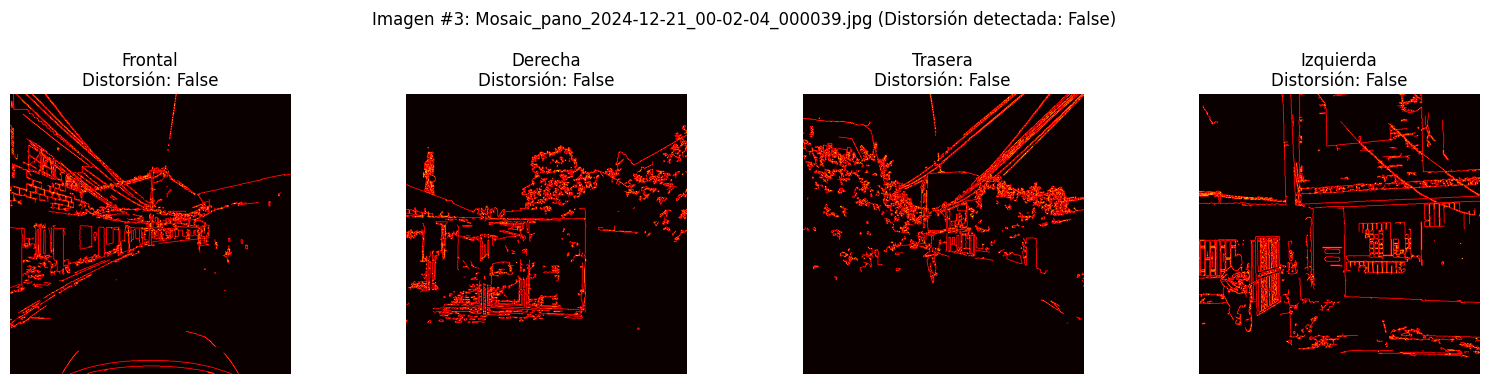

In [24]:
import random
print("Imagenes aleatorias de muestra:")
if len(resultados) >= 3:
    imagen = random.sample(resultados, 3)
else:
    imagen = resultados
mostrar_varias_imagenes(imagen, n=len(imagen))
mostrar_heatmaps(imagen, n=len(imagen))


No se encontraron imágenes con distorsión.
Imágenes con mala exposición (4 caras):


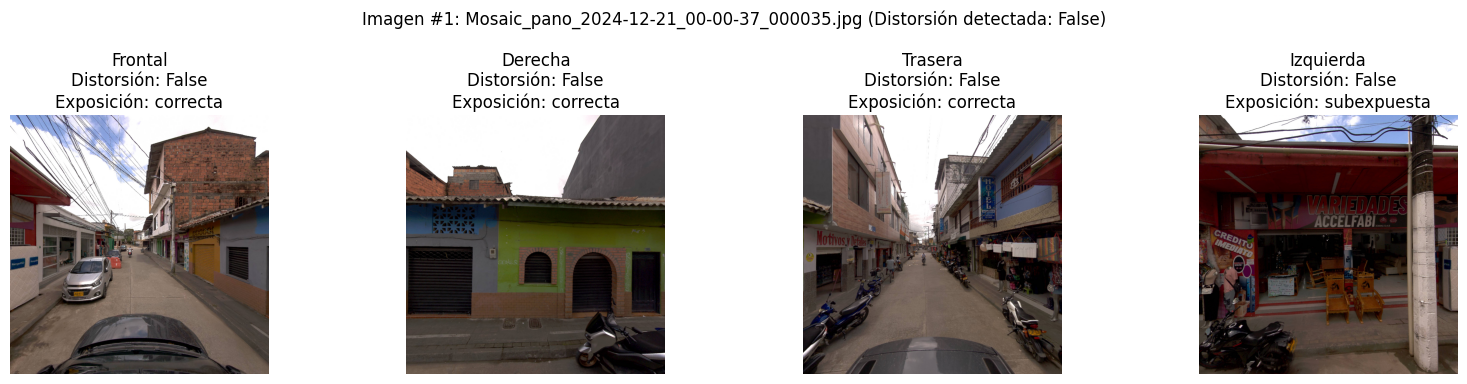

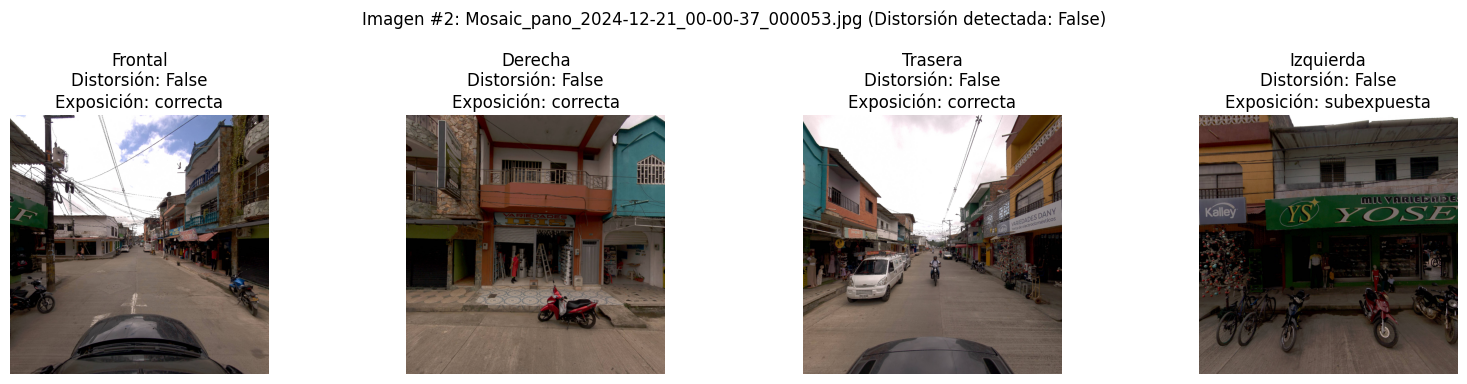

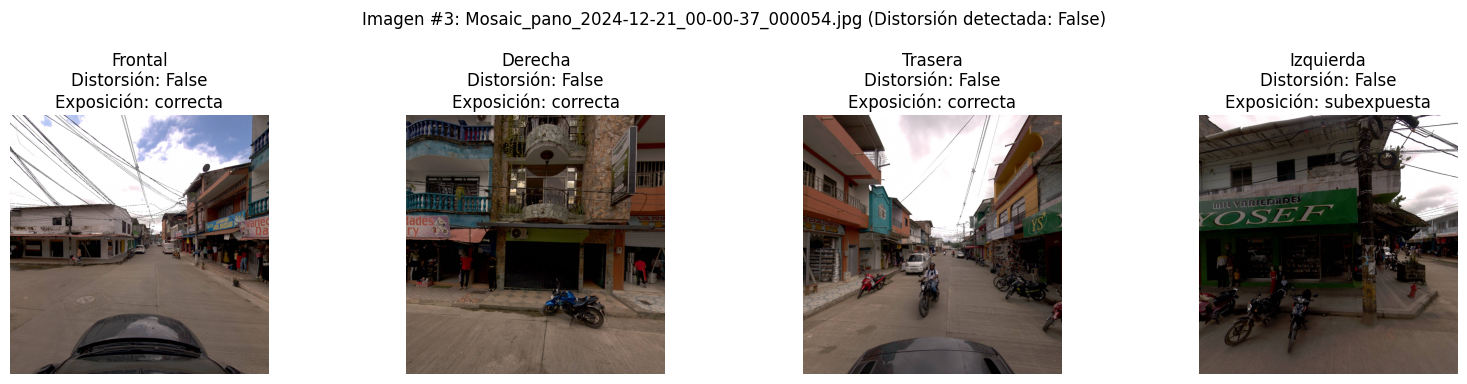

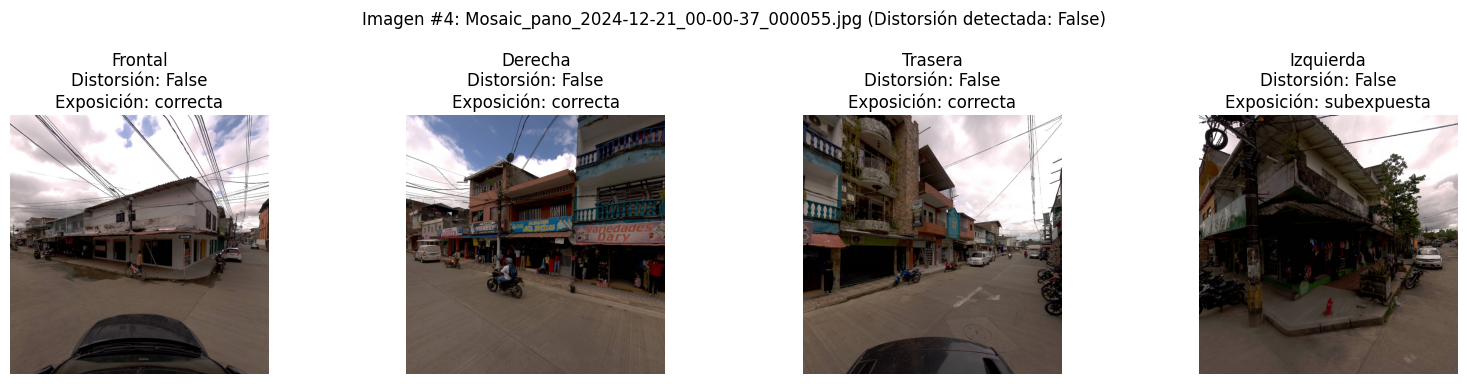

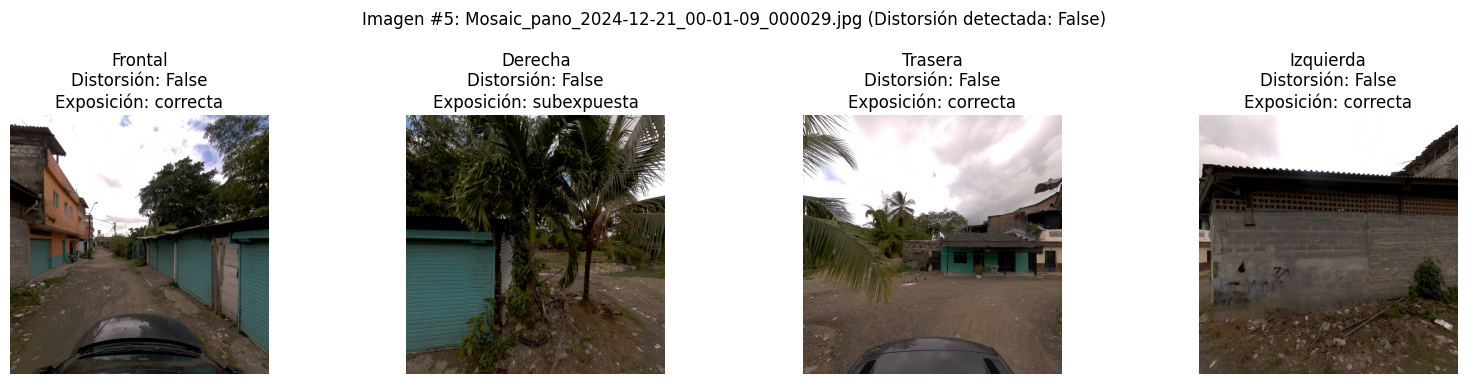

Mapas de calor de exposición:


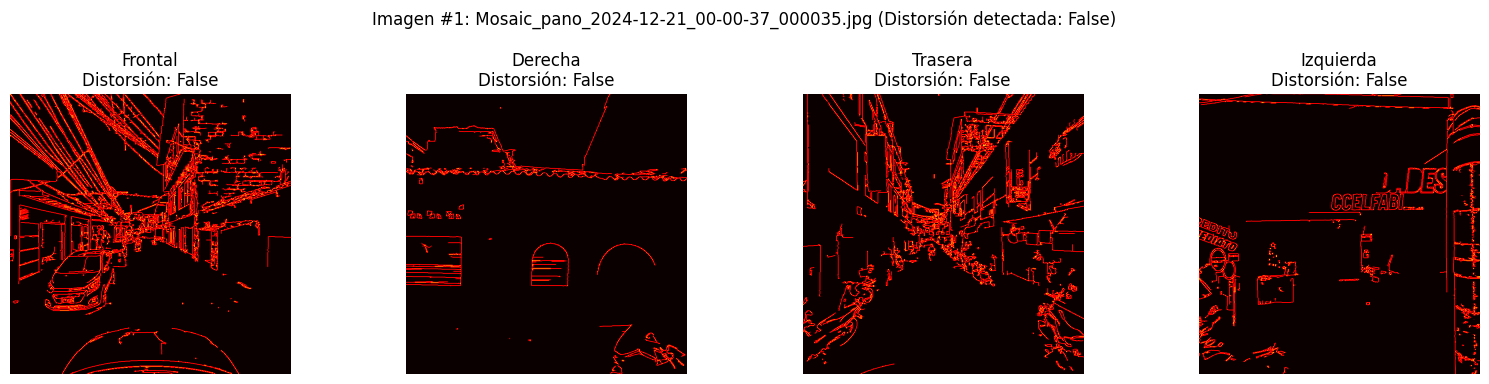

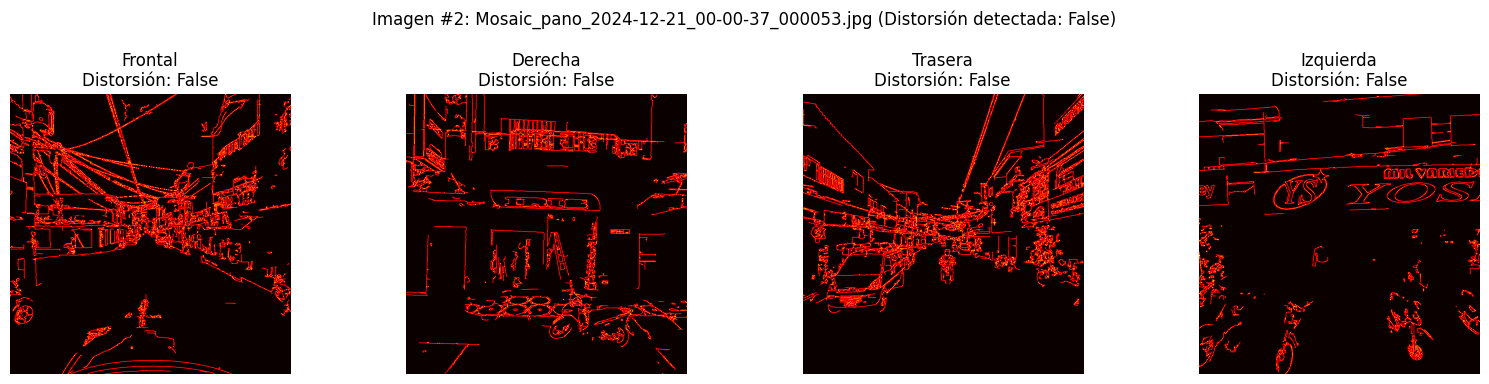

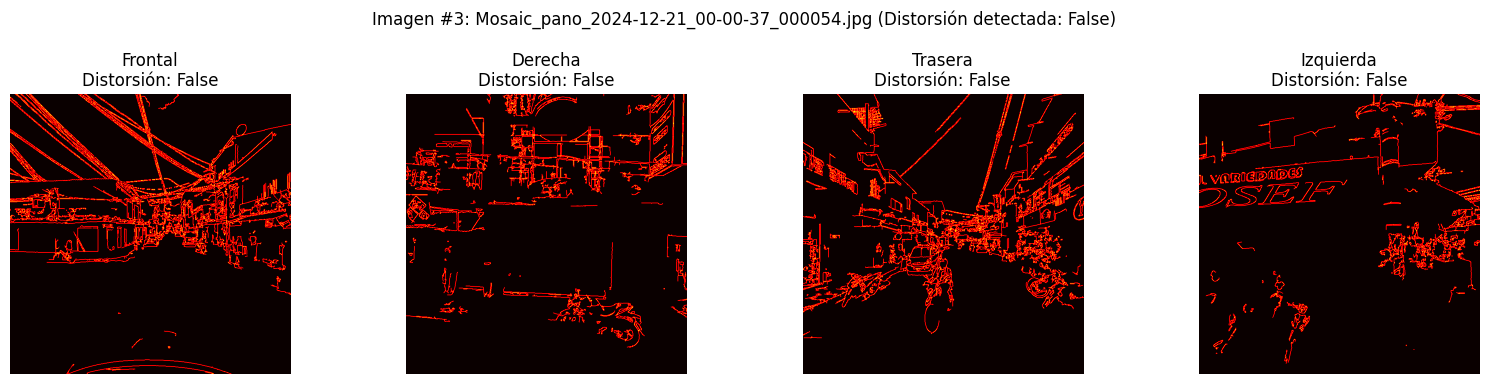

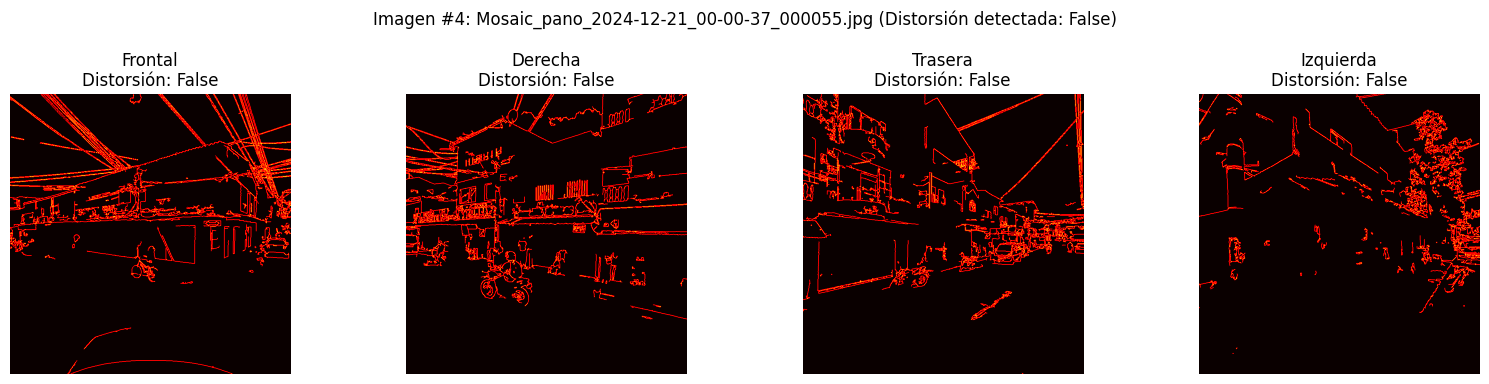

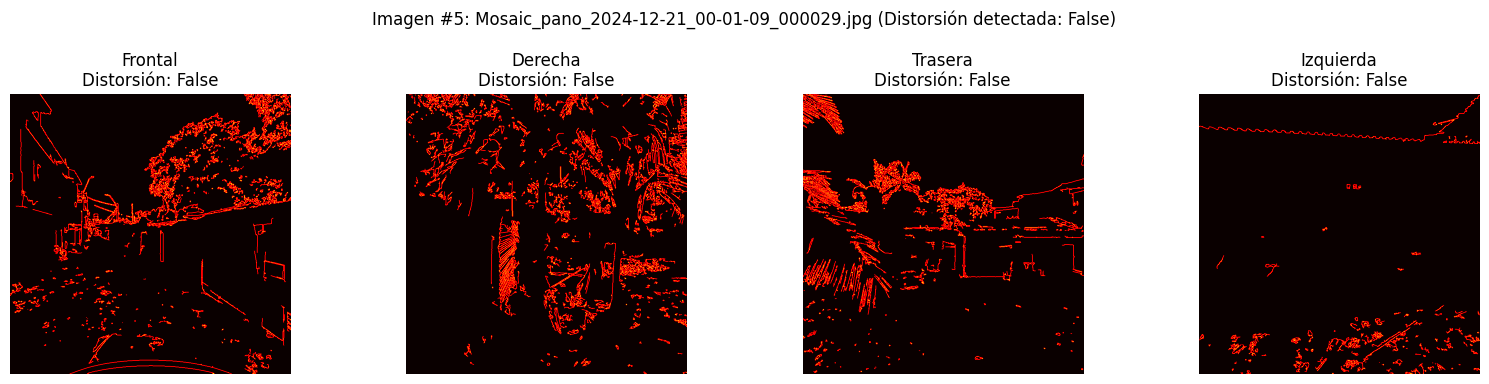

In [ ]:
# Seleccionar imágenes con distorsión y con exposición mala
imagenes_distorsion = [fila for fila in resultados_filtrados if fila['distorsion'] is True][:5]
imagenes_exposicion = [fila for fila in resultados_filtrados if fila['exposicion'] is True][:5]

# Mostrar imágenes con distorsión
if imagenes_distorsion:
    print("Imágenes con distorsión:")
    mostrar_varias_imagenes(imagenes_distorsion, n=len(imagenes_distorsion))
    print("Mapas de calor de distorsión:")
    mostrar_heatmaps(imagenes_distorsion, n=len(imagenes_distorsion))
else:
    print("No se encontraron imágenes con distorsión.")

# Mostrar imágenes con mala exposición
if imagenes_exposicion:
    print("Imágenes con mala exposición:")
    mostrar_varias_imagenes(imagenes_exposicion, n=len(imagenes_exposicion))
  
else:
    print("No se encontraron imágenes con mala exposición.")


#### **Machine Learning**
---

In [ ]:
# Configuración
batch_size = 16
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Cargar datos
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Modelo base
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 clases: fachada / no fachada
model = model.to(device)

# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# Validación rápida
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Precision:{correct / total:.2%}")
torch.save(model.state_dict(), model_path)


Epoch 1/5, Loss: 0.1627
Epoch 2/5, Loss: 0.0395
Epoch 3/5, Loss: 0.0113
Epoch 4/5, Loss: 0.0037
Epoch 5/5, Loss: 0.0011
Modelo guardado en C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\modelo_fachadas.pth


In [ ]:
from PIL import Image

def predict_image(image_path, model, transform):
    model.eval()
    image = transform(Image.open(image_path)).unsqueeze(0).to(device)
    output = model(image)
    _, pred = torch.max(output, 1)
    return pred.item()  # 0 = no fachada, 1 = fachada


In [13]:
start_time = time.time()
total_imgs = len([f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
procesadas = 0
last_report = time.time()

with open(csv_file, mode='w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    # Encabezado
    writer.writerow([
        'archivo',
        'fachada_frontal', 'fachada_derecha', 'fachada_trasera', 'fachada_izquierda',
        'distorsion_frontal', 'distorsion_derecha', 'distorsion_trasera', 'distorsion_izquierda',
        'distorsion'  # Nueva columna: 1 si alguna cara tiene distorsión, 0 si ninguna
    ])
    for img_name in os.listdir(input_folder):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            # Extraer cubemap (4 caras)
            cubemap = py360convert.e2c(img, face_w=224, mode='nearest', cube_format='list')
            fachada_caras = []
            distorsion_caras = []
            # Clasificar cada cara
            for cara in cubemap[:4]:
                x = transform(cara).unsqueeze(0).to(device)
                with torch.no_grad():
                    out = model(x)
                    fachada = torch.sigmoid(out).item() > 0.5
                fachada_caras.append(int(fachada))
                # Analizar distorsión en todas las caras
                distorsion = analizar_distorsion(cara)
                distorsion_caras.append(int(distorsion))
            # Nueva lógica: guardar siempre, y calcular distorsion global
            distorsion_global = int(any(distorsion_caras))
            writer.writerow([
                img_name,
                *fachada_caras,
                *distorsion_caras,
                distorsion_global
            ])
            procesadas += 1
            # Mostrar tiempo estimado cada minuto
            if time.time() - last_report > 60 or procesadas == total_imgs:
                elapsed = time.time() - start_time
                avg_time = elapsed / procesadas if procesadas else 0
                remaining = avg_time * (total_imgs - procesadas)
                print(f"Procesadas: {procesadas}/{total_imgs} | "
                      f"Transcurrido: {elapsed/60:.2f} min | "
                      f"Restante: {remaining/60:.2f} min")
                last_report = time.time()
print(f"Resultados guardados en {csv_file}")

Procesadas: 64/512 | Transcurrido: 1.00 min | Restante: 7.01 min
Procesadas: 133/512 | Transcurrido: 2.01 min | Restante: 5.73 min
Procesadas: 199/512 | Transcurrido: 3.02 min | Restante: 4.74 min
Procesadas: 264/512 | Transcurrido: 4.05 min | Restante: 3.80 min
Procesadas: 334/512 | Transcurrido: 5.06 min | Restante: 2.70 min
Procesadas: 403/512 | Transcurrido: 6.06 min | Restante: 1.64 min
Procesadas: 477/512 | Transcurrido: 7.06 min | Restante: 0.52 min
Procesadas: 512/512 | Transcurrido: 7.59 min | Restante: 0.00 min
Resultados guardados en C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\historial_analisis.csv
